In [1]:
from qiskit import QuantumCircuit, Aer, assemble, transpile, execute
from qiskit.circuit import ClassicalRegister, QuantumRegister
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd
from fractions import Fraction
from qiskit.quantum_info.operators import Operator

p = 8
a = 7
N = 15

#Inverse Quantum Fourier Transform
def qft_dagger(n):
    qc = QuantumCircuit(n)

    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc_U = qc.to_gate()
    qc_U.name = 'QFT†'
    return qc_U

#This function will return a ControlledGate object which repeats the action of U, 2^k times
def cU_multi(k,a,N):
    m = int(np.ceil(np.log2(N)))
#######################################################################################################    
    U_qc = QuantumCircuit(m)
    U_qc.x(range(m))
    U_qc.swap(1, 2)
    U_qc.swap(2, 3)
    U_qc.swap(0, 3)
    U = U_qc.to_gate()
    U.name ='{}Mod{}'.format(a, N)
#######################################################################################################
    sys_register_size = m
    circ = QuantumCircuit(sys_register_size)

    for _ in range(2**k):
        circ.append(U, range(sys_register_size))

    U_multi = circ.to_gate()
    U_multi.name = '7Mod15_[2^{}]'.format(k)  
    cU_multi = U_multi.control()
    
    return cU_multi


def shor_qpe(k,a,N):
    it = 0
    m = int(np.ceil(np.log2(N)))
      
    #Step 1. Begin a while loop until a nontrivial guess is found
    ### Your code goes here ###
    
    while it !=2:   
        it = 0
        target = list(range(k,k+m))
        
        #Step 2a. Construct a QPE circuit with m phase count qubits
        #  to guess the phase phi = s/r using the function cU_multi()
        ### Your code goes here ###
        
        qc = QuantumRegister(k, 'q')
        qcU = QuantumRegister(m, 'U')
        cl = ClassicalRegister(k, 'c')
        qpe = QuantumCircuit(qc,cl)
        
        qpe.add_register(qcU)
        qpe.x(k)
        
        for reg1 in range(k):
            qpe.h(qc[reg1])
        
        for qubit in range(k):
            qpe.append(cU_multi(qubit,a,N),[qubit]+target)    
        
        qpe.append(qft_dagger(k),range(k))
        
        for mr in range(k):
            qpe.measure(qc[mr],cl[mr])
            
        #Step 2b. Run the QPE circuit with a single shot, record the results
        # and convert the estimated phase bitstring to decimal
        ### Your code goes here ###
        
        sim = Aer.get_backend('aer_simulator')
        shots = 1
        shor_qpe_counts = execute(qpe, sim, shots=shots).result().get_counts()       
        
        for output in shor_qpe_counts:
            decimal = int(output,2)
            phase = decimal/(2**k)
            
        #Step 3. Use the Fraction object to find the guess for r
        ### Your code goes here ###
        
        fraction_obj = Fraction(phase).limit_denominator(N)
        r = fraction_obj.denominator
        
        #Step 4. Now that r has been found, use the builtin greatest common deonominator
        # function to determine the guesses for a factor of N
        
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]

        #Step 5. For each guess in guesses, check if at least one is a non-trivial factor
        # i.e.  (guess != 1 or N) and (N % guess == 0)
        ### Your code goes here ###
        
        for guess in guesses:
            if (guess != 1 and guess != N and N % guess == 0):
                it += 1   
    return guesses


dividers = shor_qpe(p,a,N)
print(dividers)

[3, 5]


In [3]:
from qiskit import QuantumCircuit, Aer, execute
from qiskit.circuit import ClassicalRegister, QuantumRegister
import numpy as np
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from math import gcd


def qft_dagger2(qc, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)

    return qc


def cU_multi2(U_qc,m):    
    U_qc.x(range(m))
    U_qc.swap(1, 2)
    U_qc.swap(2, 3)
    U_qc.swap(0, 3)
    
    return U_qc


def qpe_circuit(phase_register_size,unitary_register_size):
    target = list(range(phase_register_size, phase_register_size + unitary_register_size))
    
    qc = QuantumRegister(phase_register_size, 'q')
    qcU = QuantumRegister(unitary_register_size, 'U')
    cl = ClassicalRegister(phase_register_size, 'c')
    qpe = QuantumCircuit(qc,cl)
    
    qpe.add_register(qcU)
    qpe.x(phase_register_size)
    
    for reg1 in range(phase_register_size):
        qpe.h(qc[reg1])
   
    qpe.barrier()
    for qubit in range(phase_register_size):
        qpe.append(cU_multi(qubit,a,N),[qubit]+target)
      
    qpe.barrier()    
    qpe.append(qft_dagger(phase_register_size),range(phase_register_size))
    
    qpe.barrier()
    for mr in range(phase_register_size):
        qpe.measure(qc[mr],cl[mr])
    
    return qpe

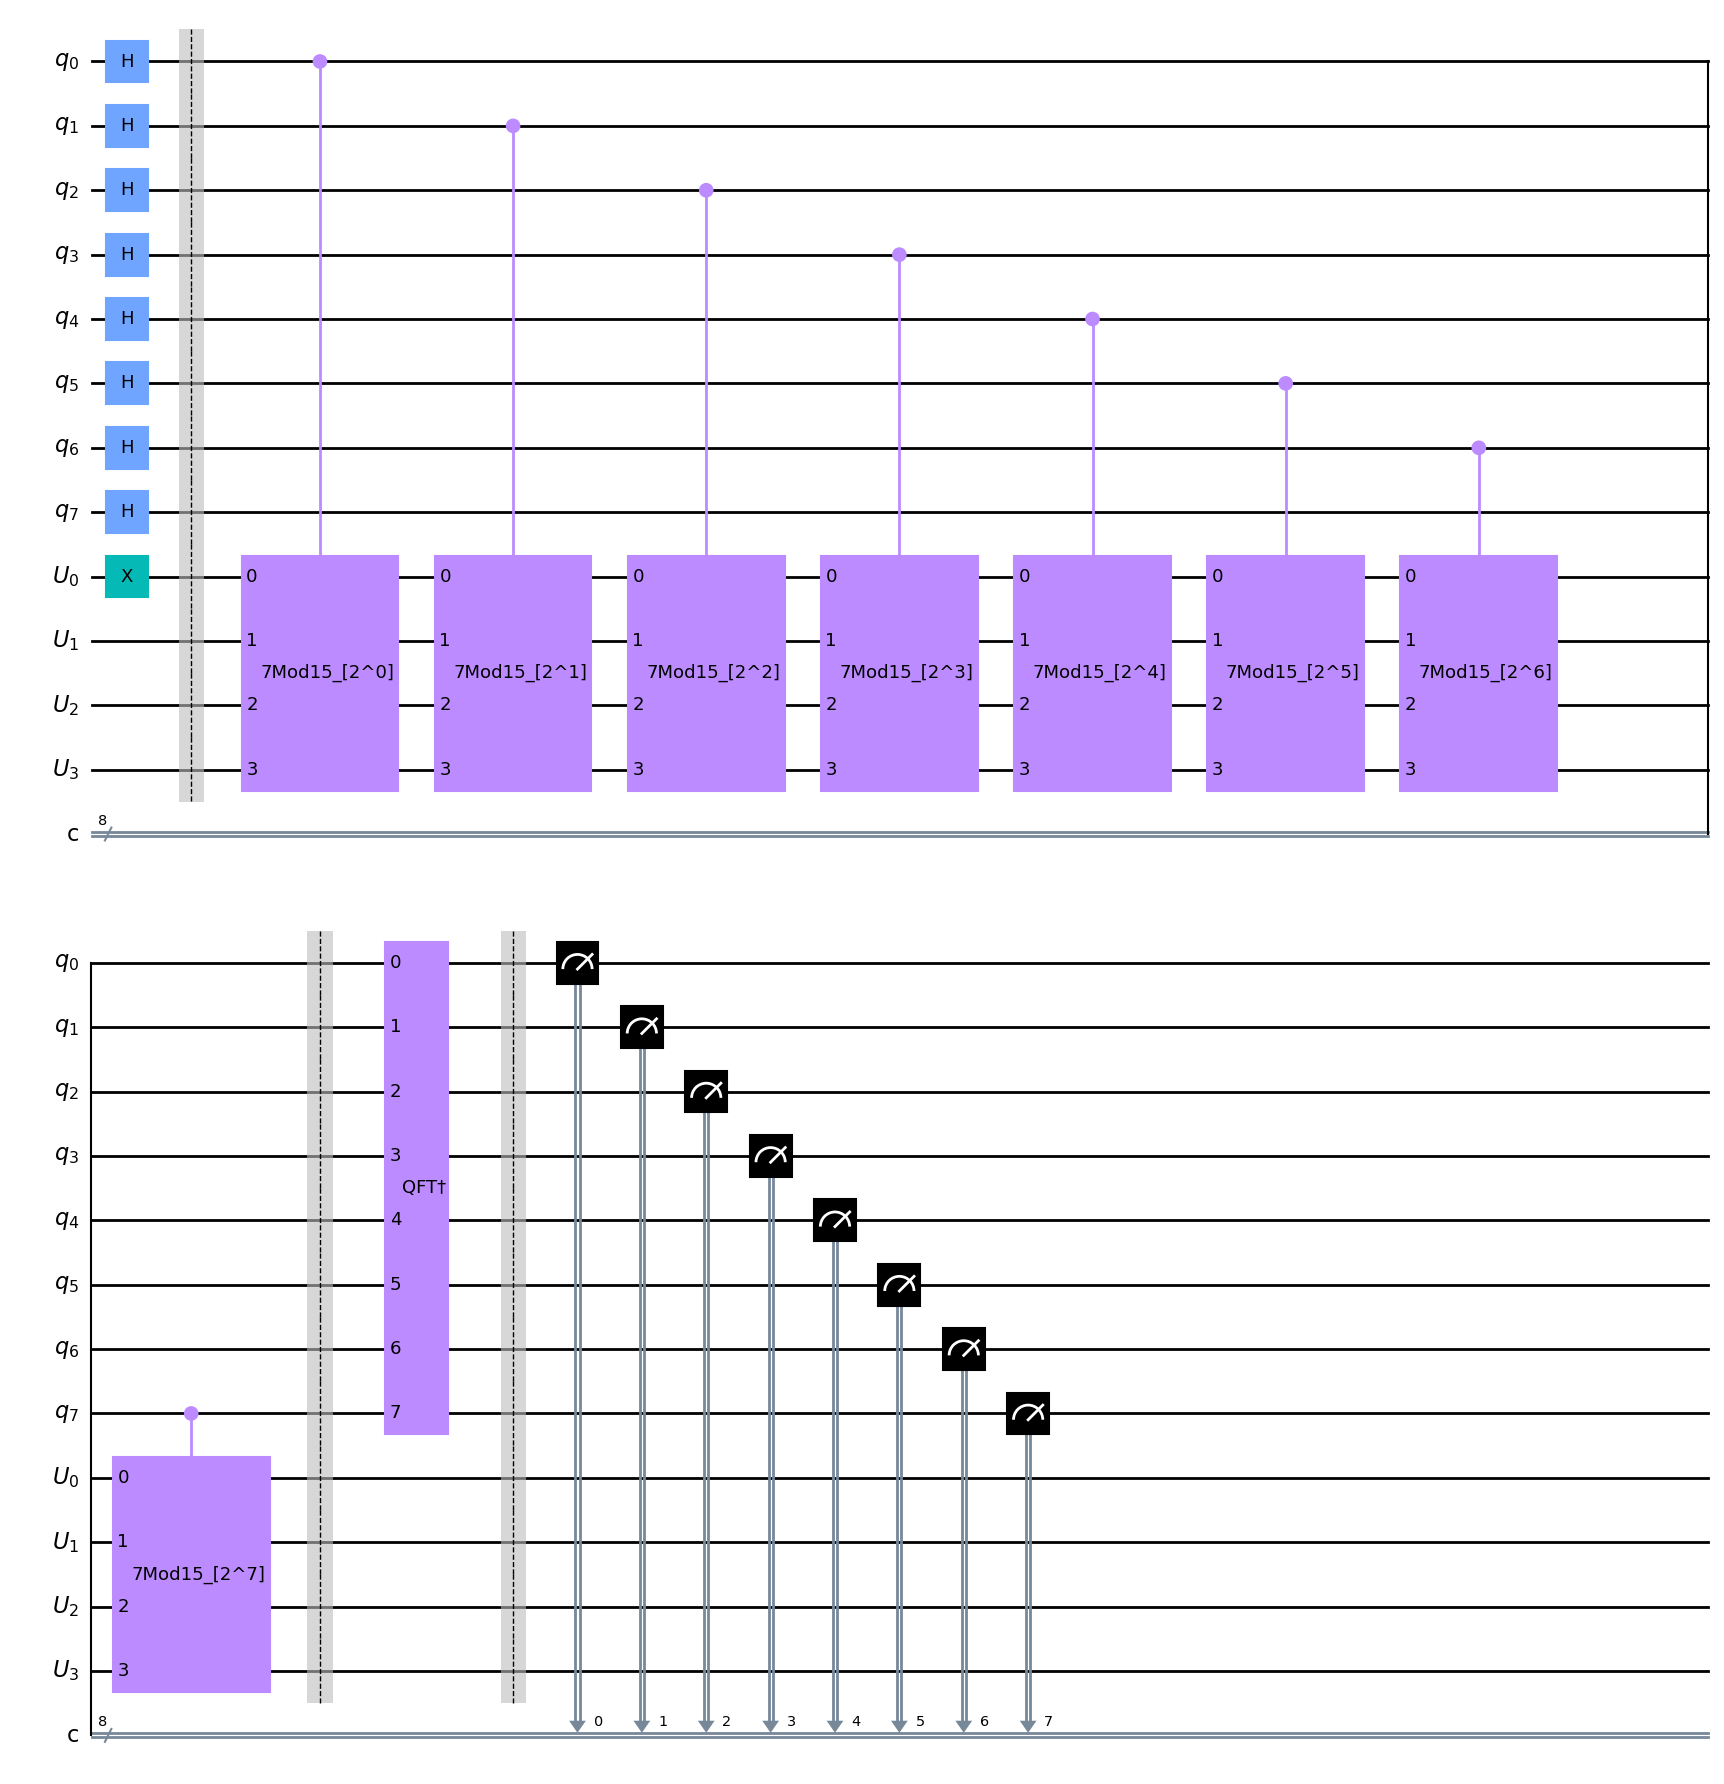

In [4]:
p2 = int(np.ceil(np.log2(N)))
shor_qpe = qpe_circuit(p,p2)
shor_qpe.draw('mpl')

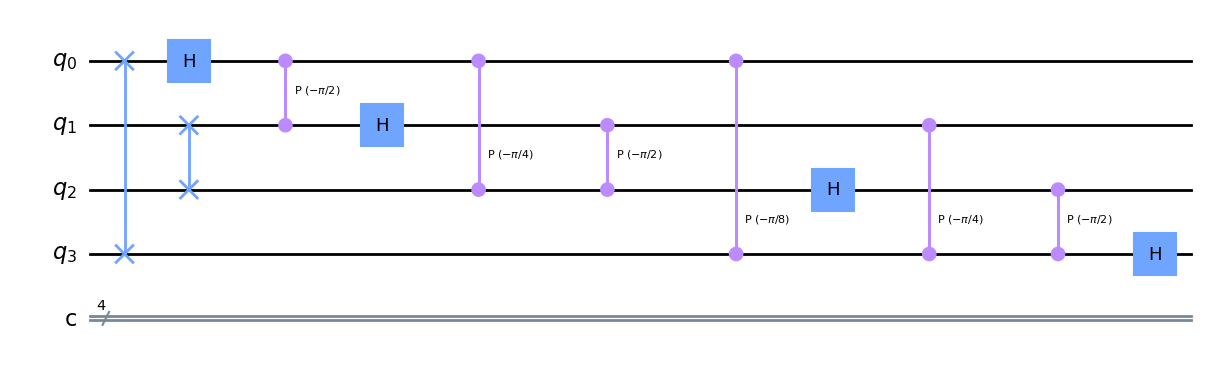

In [9]:
phase_register_size = int(np.ceil(np.log2(N)))
qc = QuantumRegister(phase_register_size, 'q')
cl = ClassicalRegister(phase_register_size, 'c')
qpe4 = QuantumCircuit(qc,cl)

qft_dagger2(qpe4, phase_register_size)
 
qpe4.draw('mpl')

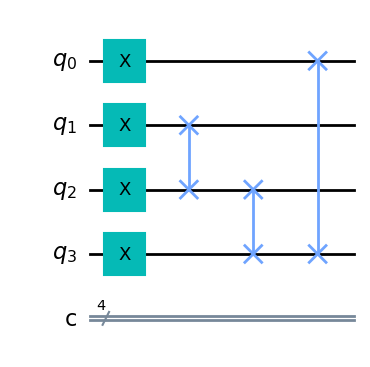

In [11]:
phase_register_size = int(np.ceil(np.log2(N)))
qc = QuantumRegister(phase_register_size, 'q')
cl = ClassicalRegister(phase_register_size, 'c')
qpe4_2 = QuantumCircuit(qc,cl)

cU_multi2(qpe4_2,phase_register_size)

qpe4_2.draw('mpl')